In [51]:
# Import libraries
from datetime import datetime
from functools import reduce
from itertools import combinations
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pickle
import xgboost as xgb
import sys
import local_functions as lf
print(sys.version)
xgb.__version__

3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:48) [Clang 13.0.0 (clang-1300.0.29.30)]


'2.0.3'

In [52]:
## LIST OF CHEMICAL CLEANINGS DATES ON DF PERIOD

Chemical_days = [
    '15-06-2022',
    '16-06-2022',
    '25-10-2022',
    '27-10-2022',
    '02-01-2023',
    '08-03-2023',
    '15-04-2023',
    '17-04-2023',
    '14-06-2023',
    '21-08-2023',
    '16-10-2023',
    '08-01-2024',
    '18-03-2024']
Chemical_days = [datetime.strptime(fecha, '%d-%m-%Y').date() for fecha in Chemical_days]


In [53]:
# Read data
df0 = pd.read_csv('CSVs/R3A_Cicles_Inf.csv')
df0.columns = ['ID','Date','Qair', 'Qperm', 'TMP', 'O2','Temp', 'TSS', 'NH4', 'NO3','Flux', 'Permeab', 'Hz']
df0.sort_values(by = 'Date', inplace = True)
df0.dropna(inplace=True)
df0.drop(['ID'], axis=1, inplace = True)
df0['Date'] = pd.to_datetime(df0['Date'])
df0.reset_index(drop = True, inplace = True)
df0.head(5)

,Date,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz
0,2022-10-05 08:25:20,3906.94,44.0000,-0.156667,5.67800,24.4253,11.7480,0.0,5.70733,11.4583,73.3809,29.0
1,2022-10-05 08:35:44,3902.02,44.6562,-0.157500,1.03125,24.4263,11.6931,0.0,6.18687,11.6292,73.9542,29.0
2,2022-10-05 08:45:46,3903.80,44.5187,-0.157500,0.11625,24.4125,11.7094,0.0,5.73125,11.5934,73.7207,29.0
3,2022-10-05 08:55:46,3909.99,44.8750,-0.158125,0.10125,24.3500,11.6125,0.0,5.60000,11.6862,74.0234,29.0
4,2022-10-05 09:05:46,3909.84,44.6125,-0.157500,0.10125,24.3369,11.5850,0.0,5.01500,11.6178,73.8709,29.0


In [54]:
# DATA TREATMENT
# Set absolute valure for TMP (there is no backwash is flat sheet)
df0['TMP'] = abs(df0['TMP'])

# For de Fouling Rates (FR) calculatios, set time in minutes and tmp to mbar
df0['Minute'] = (df0['Date']-df0['Date'].iloc[0]).dt.total_seconds()/60
df0['TMPmbar'] = df0['TMP']*1000
df0['FR'] = lf.calcualte_slope(df0,n = 5, Name_TMP='TMPmbar',Name_Time='Minute')

# For the chemical cleanings information
df0['Days'] = df0['Date'].dt.date
df0['Chemicals'] = np.zeros(len(df0))
df0['Chemicals'] = df0['Days'].isin(Chemical_days).astype(int)
print(f'N rows with chemicals cleanings: {sum(df0['Chemicals'])}')

# Calcualte days after each chemical cleaning
reset_points = df0['Chemicals'].cumsum()
df0['After_Chemical_h'] = df0.groupby(reset_points)['Minute'].transform(lambda x: (x - x.min()) / 60)
print(f'NaN found: {df0.isna().values.any()}')

# Calculate total resistance
df0['Visco'] = 1.793 * 10**-3 * np.exp(-0.043 * df0['Temp']**0.864)
df0['Resistance'] = (df0['TMP']*3600*1000*1000)/(df0['Flux']*df0['Visco'])
df0.columns

N rows with chemicals cleanings: 559
NaN found: False


Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')

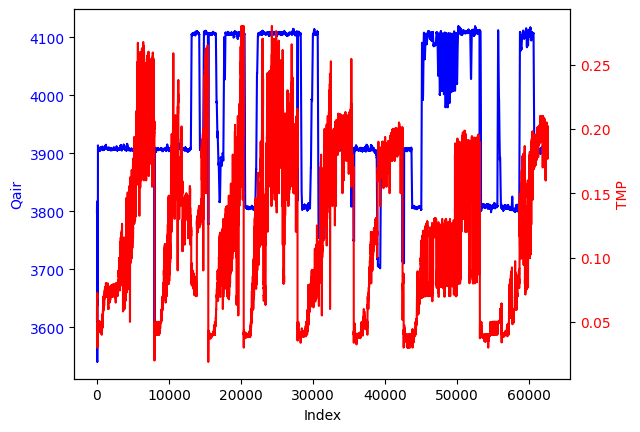

,Date,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz,Minute,TMPmbar,FR,Days,Chemicals,After_Chemical_h,Visco,Resistance
0,2022-10-25 17:32:42,3798.332051,34.4917,0.051667,0.110000,24.2433,13.3725,4.47417,2.00000,8.98220,178.584,25.0,29347.366667,51.6667,-0.217365,2022-10-25,1,0.0,0.000912,2.269887e+10
1,2022-10-25 17:46:29,3799.608451,35.3647,0.067647,0.110000,24.2412,13.0488,4.58176,1.99882,9.20956,134.943,25.0,29361.150000,67.6471,-0.204994,2022-10-25,1,0.0,0.000912,2.898442e+10
2,2022-10-25 18:00:01,3800.222151,45.8455,0.070000,0.110000,24.2636,12.9827,4.69727,1.95818,11.93890,170.556,26.0,29374.683333,70.0000,-0.196996,2022-10-25,1,0.0,0.000912,2.314847e+10
3,2022-10-25 20:21:01,3801.478051,27.0882,0.063922,0.571176,24.5094,12.5061,2.14490,7.87843,7.05423,109.937,25.0,29515.683333,63.9216,-0.177787,2022-10-25,1,0.0,0.000906,3.598779e+10
4,2022-10-25 20:53:59,3802.565751,25.1500,0.060000,0.110000,24.4875,12.3125,2.12063,6.39875,6.54948,109.725,25.0,29548.650000,60.0000,0.047267,2022-10-25,1,0.0,0.000907,3.636410e+10


In [55]:
# Set a copy of the DF0 to work with
df = df0.copy()
# Do a rolling mean for the air scour flow to reduce the noise
df['Qair'] = lf.rolling_mean_centered(df['Qair'].values, 100)
# Exclude the iniial and end values fue to are not representative
df = df.iloc[2370:65041]
df.reset_index(drop = True, inplace = True)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df['Qair'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Qair', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['TMP'], color='red')
ax2.set_ylabel('TMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()
df.head()

In [56]:
# Resamplt the df to get one value each hour
dfi = df.copy()
dfi.drop(['Days'], axis = 1, inplace = True)
dfi.set_index('Date', inplace = True)
dfi = dfi.resample('60min').median()
print(dfi.index)

DatetimeIndex(['2022-10-25 17:00:00', '2022-10-25 18:00:00',
               '2022-10-25 19:00:00', '2022-10-25 20:00:00',
               '2022-10-25 21:00:00', '2022-10-25 22:00:00',
               '2022-10-25 23:00:00', '2022-10-26 00:00:00',
               '2022-10-26 01:00:00', '2022-10-26 02:00:00',
               ...
               '2024-03-16 12:00:00', '2024-03-16 13:00:00',
               '2024-03-16 14:00:00', '2024-03-16 15:00:00',
               '2024-03-16 16:00:00', '2024-03-16 17:00:00',
               '2024-03-16 18:00:00', '2024-03-16 19:00:00',
               '2024-03-16 20:00:00', '2024-03-16 21:00:00'],
              dtype='datetime64[ns]', name='Date', length=12197, freq='60min')


Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')


,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz,Minute,TMPmbar,FR,Chemicals,After_Chemical_h,Visco,Resistance,TargetTMP
Date,,,,,,,,,,,,,,,,,,,
2022-10-25 17:00:00,3798.970251,34.92820,0.059657,0.110000,24.24225,13.21065,4.527965,1.99941,9.095880,156.76350,25.0,29354.258333,59.6569,-0.211180,1.0,0.0,0.000912,2.584164e+10,0.05
2022-10-25 18:00:00,3800.222151,45.84550,0.070000,0.110000,24.26360,12.98270,4.697270,1.95818,11.938900,170.55600,26.0,29374.683333,70.0000,-0.196996,1.0,0.0,0.000912,2.314847e+10,0.05
2022-10-25 20:00:00,3802.021901,26.11910,0.061961,0.340588,24.49845,12.40930,2.132765,7.13859,6.801855,109.83100,25.0,29532.166667,61.9608,-0.065260,1.0,0.0,0.000907,3.617594e+10,0.05
2022-10-25 21:00:00,3806.424601,26.40310,0.067500,0.110000,24.44190,12.17405,3.613435,4.93813,6.875815,101.79500,25.0,29583.691667,67.5000,0.037297,1.0,0.0,0.000908,3.910801e+10,0.05
2022-10-25 22:00:00,3813.044701,26.14375,0.068438,0.110000,24.44125,12.07215,3.456870,4.36344,6.808265,99.05135,25.0,29643.750000,68.4375,0.016047,1.0,0.0,0.000908,4.013260e+10,0.05


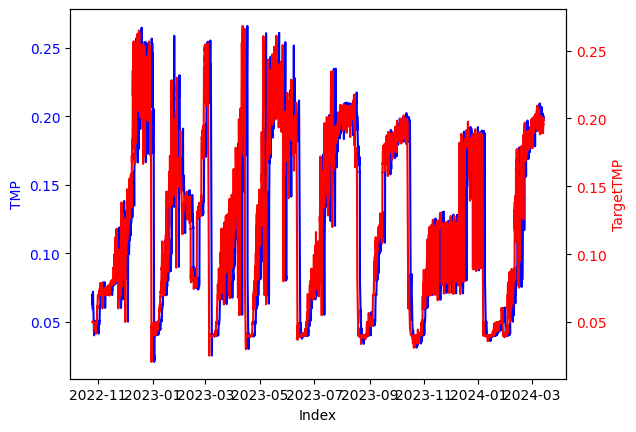

In [57]:
# Se the days to forecast
# It will create a TMP colum pinting to the "future" ccroding the actual TMP as well
target_days = 3 
dfi['TargetTMP'] = dfi['TMP'].shift(-target_days*24)
dfi.dropna(inplace = True)

# Plot TMP and target TMP
fig, ax1 = plt.subplots()
ax1.plot(dfi.index, dfi['TMP'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(dfi.index, dfi['TargetTMP'], color='red')
ax2.set_ylabel('TargetTMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

print(dfi.columns)
dfi.head()

In [35]:
dfi.columns

Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')

Text(0, 0.5, 'Explained variance ratio')

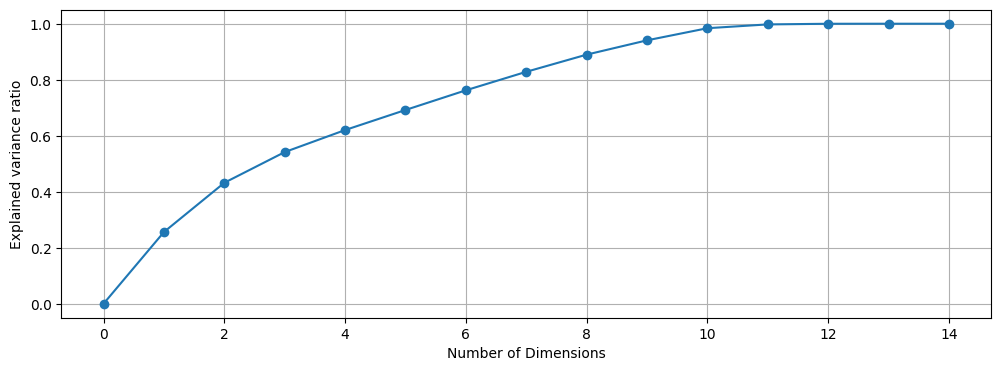

In [36]:
# Perform a PCA
# Stabndarusation
from sklearn.preprocessing import StandardScaler
xcolumns = ['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
            'FR', 'Chemicals','After_Chemical_h', 'Visco', 'Resistance']
scaler = StandardScaler()
dfx_scaled = scaler.fit_transform(dfi[xcolumns])

# apply PCA
from sklearn.decomposition import PCA

var_ratio = []
dimensions = np.arange(len(xcolumns)+1)
for dim in dimensions:
    pca = PCA(n_components = dim)
    pca.fit(dfx_scaled)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(12,4))
plt.grid()
plt.plot(dimensions,var_ratio,marker = 'o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained variance ratio')

In [37]:
# PErformPCA with 10 components

pca = PCA(n_components=10)
pca.fit(dfx_scaled)
components = pca.components_
component_loadings = pd.DataFrame(components, columns=xcolumns)
component_loadings.index = [f'PC{i+1}' for i in range(components.shape[0])]
print(component_loadings)
component_loadings.shape

          Qair     Qperm       TMP        O2      Temp       TSS       NH4  \
PC1   0.202686 -0.423686  0.364347  0.122632  0.093095 -0.073355 -0.098165   
PC2   0.173447 -0.023158 -0.010677  0.243117 -0.595306  0.360844 -0.177926   
PC3  -0.185493 -0.422561 -0.496497  0.249448  0.098935  0.170019 -0.168296   
PC4   0.387770 -0.028527 -0.186637 -0.392609  0.116463  0.197457 -0.210931   
PC5   0.278536  0.008637  0.036277  0.021491 -0.101764 -0.261871  0.526314   
PC6  -0.094513 -0.024579 -0.002059  0.061557  0.045123  0.039870 -0.185681   
PC7   0.145934  0.088329  0.101529 -0.494905  0.005690  0.102597 -0.492930   
PC8  -0.467685  0.208743  0.199648  0.317825  0.035338 -0.194773 -0.423138   
PC9  -0.358642  0.059540  0.119329 -0.104921  0.114186  0.756412  0.369681   
PC10  0.535782  0.222388  0.060291  0.587917  0.259829  0.272931 -0.100635   

           NO3      Flux        FR  Chemicals  After_Chemical_h     Visco  \
PC1   0.046635 -0.423686 -0.019208  -0.011435          0.421830 

(10, 14)

In [38]:
# Calcular las cargas absolutas
abs_loadings = component_loadings.abs()

# Sumar las cargas a través de los 10 componentes para cada variable
variable_importance = abs_loadings.sum(axis=0)

# Ordenar las variables según la importancia (suma de cargas absolutas)
sorted_importance = variable_importance.sort_values(ascending=False)

print("Importancia de las variables en los 10 componentes principales:")
print(sorted_importance)


Importancia de las variables en los 10 componentes principales:
Qair                2.830487
NH4                 2.753697
O2                  2.596421
NO3                 2.445399
TSS                 2.430130
Chemicals           2.299201
FR                  1.826315
TMP                 1.577290
Visco               1.514152
Flux                1.510148
Qperm               1.510148
Temp                1.465729
After_Chemical_h    1.440728
Resistance          1.182543
dtype: float64


In [45]:
# Model with the most relevant varaibles according PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import xgboost as xgb
import itertools

linear_results = {}
sorted_variables = sorted_importance.index


x_train, x_test, y_train, y_test = train_test_split(dfi[xcolumns], dfi['TargetTMP'], test_size=0.75, random_state=42)

for r in range(1,len(sorted_variables)+1):
    for combo in itertools.combinations(sorted_variables,r):
        combo_name = ', '.join(combo)
        xtrain_s = x_train[list(combo)]
        xtest_s = x_test[list(combo)]

        model = LinearRegression()
        model.fit(xtrain_s, y_train)

        y_pred = model.predict(xtest_s)
        r2 = r2_score(y_test, y_pred)
        linear_results[combo_name] = r2

linear_results_df = pd.DataFrame(list(linear_results.items()), columns=['Combination', 'R2'])
linear_results_df = linear_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print(linear_results_df.head(10))

xgb_results =  {}

for r in range(1,len(sorted_variables)+1):
    for combo in itertools.combinations(sorted_variables,r):
        combo_name = ', '.join(combo)
        xtrain_s = x_train[list(combo)]
        xtest_s = x_test[list(combo)]
        model = xgb.XGBRegressor()
        model.fit(xtrain_s, y_train)
        y_pred = model.predict(xtest_s)
        r2 = r2_score(y_test, y_pred)
        xgb_results[combo_name] = r2

xgb_results_df = pd.DataFrame(list(xgb_results.items()), columns=['Combination', 'R2'])
xgb_results_df = xgb_results_df.sort_values(by='R2', ascending=False).reset_index(drop = True)
print(xgb_results_df.head(10))

"""
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f'LR R² Score: {r2:.4f}')

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print(f'XGB R² Score: {r2:.4f}')

"""



                                         Combination        R2
0  NH4, O2, TSS, Chemicals, TMP, Visco, Flux, Qpe...  0.621599
1  NH4, O2, TSS, Chemicals, TMP, Visco, Qperm, Te...  0.621571
2  NH4, O2, TSS, Chemicals, TMP, Visco, Flux, Tem...  0.621571
3  NH4, TSS, Chemicals, TMP, Visco, Flux, Qperm, ...  0.621347
4  NH4, TSS, Chemicals, TMP, Visco, Flux, Temp, A...  0.621318
5  NH4, TSS, Chemicals, TMP, Visco, Qperm, Temp, ...  0.621318
6  O2, TSS, Chemicals, TMP, Visco, Flux, Qperm, T...  0.621300
7  NH4, O2, NO3, TSS, Chemicals, TMP, Visco, Flux...  0.621296
8  NH4, O2, TSS, Chemicals, TMP, Flux, Qperm, Tem...  0.621294
9  NH4, O2, NO3, TSS, Chemicals, TMP, Visco, Qper...  0.621281
                                         Combination        R2
0  Qair, NH4, TSS, Visco, Qperm, After_Chemical_h...  0.951241
1  Qair, NH4, TSS, Visco, Flux, Qperm, After_Chem...  0.951170
2  Qair, NH4, TSS, Chemicals, Visco, Qperm, After...  0.950964
3  Qair, NH4, TSS, Chemicals, Visco, Flux, Qperm,...  0

"\nmodel = LinearRegression()\nmodel.fit(x_train, y_train)\n\ny_pred = model.predict(x_test)\nr2 = r2_score(y_test, y_pred)\nprint(f'LR R² Score: {r2:.4f}')\n\nxgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)\n\nxgb_model.fit(x_train, y_train)\n\ny_pred = xgb_model.predict(x_test)\n\nr2 = r2_score(y_test, y_pred)\nprint(f'XGB R² Score: {r2:.4f}')\n\n"

In [59]:
print(xgb_results_df['Combination'][0])
print(dfi.columns)

Qair, NH4, TSS, Visco, Qperm, After_Chemical_h, Resistance
Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')


In [63]:
# Split data for the models

# Using the Total resistance as an imput o open the possibility to combine with a mechanistic model
X = dfi[['Qair', 'NH4', 'TSS', 'Visco', 'Qperm', 'After_Chemical_h', 'Resistance']].copy()
Y = dfi['TargetTMP'].copy()

#X.reset_index(drop = True,inplace=True)
#Y.reset_index(drop = True,inplace=True)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.75, shuffle = True)

In [ ]:
from skopt import BayesSearchCV

# Definir el modelo
model_xgb = xgb.XGBRegressor()

# Definir la rejilla de hiperparámetros para buscar
search_space = {
    'max_depth': (5, 15),
    'learning_rate': (0.001, 0.1),
    'n_estimators': (200, 600),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 0.5)
}
'''
Mejores parámetros: OrderedDict({'colsample_bytree': 0.7605356036350088, 'gamma': 0.0, 'learning_rate': 0.0462331573194408, 'max_depth': 9, 'n_estimators': 404, 'subsample': 0.905833040582313})
R2 Score: 0.9706
'''

# Configurar BayesSearchCV
bayes_search = BayesSearchCV(estimator=model_xgb, search_spaces=search_space, scoring='r2', cv=5, n_iter=100, random_state=42, n_jobs=-1, verbose=1)

# Ejecutar la búsqueda de hiperparámetros
bayes_search.fit(x_train, y_train)

# Obtener los mejores parámetros
best_params = bayes_search.best_params_
print("Mejores parámetros:", best_params)

# Entrenar el modelo final con los mejores parámetros
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(x_train, y_train)

# Evaluar el modelo
predictions = best_model.predict(x_test)
r2 = r2_score(y_test, predictions)
print(f'R2 Score: {r2:.4f}')


In [ ]:
import graphviz
# Convertir a Booster
booster_model = best_model.get_booster()

# Exportar el árbol a un archivo DOT
dot_data = xgb.to_graphviz(booster_model, num_trees=0)

# Visualizar con Graphviz
dot_data.view()

with open('xgb_model_v2.pkl','wb') as f:
    pickle.dump(best_model,f)

  Model        R2       MSE       MAE
0   XGB  0.949955  0.000204  0.008789


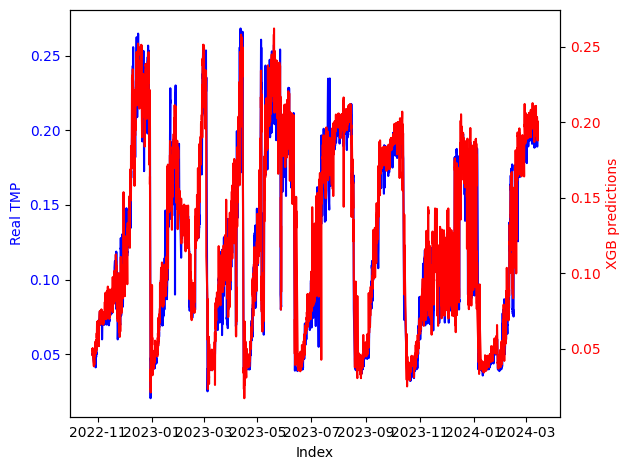

In [64]:
# XGBoost model
mdodel_xgb = xgb.XGBRegressor()
mdodel_xgb.fit(x_train, y_train)
y_xgb = mdodel_xgb.predict(x_test)

# Statistics
xgbr2   = r2_score(y_test,y_xgb)
xgb_mse = mean_squared_error( y_test,y_xgb)
xgb_mae = mean_absolute_error(y_test,y_xgb)

Metrics = pd.DataFrame()
Metrics['Model'] = ['XGB']
Metrics['R2']    = [xgbr2]
Metrics['MSE']   = [xgb_mse]
Metrics['MAE']   = [xgb_mae]
print(Metrics)

Results = y_test.to_frame(name='RealTMP')
Results['Predictions'] = y_xgb
Results = Results.sort_index(ascending=True)
# Plot
fig, ax1 = plt.subplots()
ax1.plot(Results.index, Results['RealTMP'], color='blue', label='Real TMP')
ax1.set_xlabel('Index')
ax1.set_ylabel('Real TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(Results.index, Results['Predictions'], color='red', label='XGB predictions')
ax2.set_ylabel('XGB predictions', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()

# Save model
with open('xgb_model_v1.pkl','wb') as f:
    pickle.dump(mdodel_xgb,f)

In [ ]:
# LSTM attempt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, InputLayer, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#['Qair', 'Temp', 'TSS', 'Flux', 'FR', 'Chemicals','After_Chemical_h', 'Resistance']
Col_To_Norm = ['Qair', 'Temp', 'TSS', 'Flux', 'FR', 'Chemicals', 'After_Chemical_h', 'Resistance']
X_to_norm = X[Col_To_Norm]
Y_df = Y.to_frame(name = "Target")
Y_to_norm = Y_df.copy()
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()
Xnorm = pd.DataFrame(scaler.fit_transform(X_to_norm), columns=Col_To_Norm, index=X.index)
Ynorm = pd.DataFrame(scaler.fit_transform(Y_to_norm), columns=Y_to_norm.columns, index=Y.index)
# Reasignando la columna original
Xnorm['After_Chemical_h'] = X['After_Chemical_h']

# Creando las gráficas
ig, axes = plt.subplots(nrows=len(X.columns)+1, ncols=1, figsize=(10, 25))

# Creando las gráficas para X y Xnorm
for i, col in enumerate(X.columns):
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    ax1.plot(X.index, X[col], label='Original', color='blue')
    if col in Xnorm.columns:
        ax2.plot(X.index, Xnorm[col], label='Normalizado', color='orange')
    
    ax1.set_title(f'Comparación de {col}')
    ax1.set_ylabel('Original', color='blue')
    ax2.set_ylabel('Normalizado', color='orange')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Graficando Y y Ynorm en el último subplot
ax1 = axes[len(X.columns)]
ax2 = ax1.twinx()

ax1.plot(Y_df.index, Y_df['Target'], label='Y Original', color='green')
ax2.plot(Ynorm.index, Ynorm['Target'], label='Y Normalizado', color='red')

ax1.set_title(f'Comparación de Target')
ax1.set_ylabel('Y Original', color='green')
ax2.set_ylabel('Y Normalizado', color='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



In [ ]:

def df_to_X_y(dfx, dfy, window_size=44):
    dfx_as_np = dfx.to_numpy()
    dfy_as_np = dfy.to_numpy()
    x = []
    y = []
    for i in range(len(dfx_as_np) - window_size):
        row = dfx_as_np[i:i + window_size]
        x.append(row)
        label = dfy_as_np[i + window_size]
        y.append(label)
    return np.array(x), np.array(y)

X_lstm, Y_lstm = df_to_X_y(Xnorm, Ynorm)

split_1 = int(0.5 * len(X_lstm))
split_2 = int(0.8 * len(X_lstm))

X_train, Y_train = X_lstm[:split_1], Y_lstm[:split_1]
X_val, Y_val = X_lstm[split_1:split_2], Y_lstm[split_1:split_2]
X_test, Y_test = X_lstm[split_2:], Y_lstm[split_2:]

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

model = Sequential()
model.add(InputLayer((44,8)))
model.add(LSTM(64)) 
model.add(Dense(8,'relu'))
model.add(Dense(1,'linear'))
model.summary()

cp = ModelCheckpoint('Model_LSTM.keras', save_best_only=True)
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate = 0.0001),
    metrics=[RootMeanSquaredError()]
)

model.fit(X_train,Y_train, validation_data = (X_val,Y_val),epochs = 10, callbacks = [cp])


model = load_model('Model_LSTM.keras')
train_predictions = model.predict(X_train)
train_results = pd.DataFrame(train_predictions)
train_results['Actuals'] = Y_train
train_results.columns = ['Predictions','RealTMP']

train_results.sort_index(ascending=True)
# Plot
fig, ax1 = plt.subplots()
ax1.plot(train_results.index, train_results['RealTMP'], color='blue', label='Real TMP')
ax1.set_xlabel('Index')
ax1.set_ylabel('Real TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(train_results.index, train_results['Predictions'], color='red', label='XGB predictions')
ax2.set_ylabel('LSTM Prediccitons', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()